In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

In [63]:
class RandomWalk:
    
    def __init__(self, reward_left, reward_right, case_label, initialState=0):
        self.initialState = initialState
        self.state = initialState
        
        # Set the reward signs according to the user-defined Case Label
        if case_label == 'NP':
            self.Rr = reward_right
            self.Rl = -reward_left
        elif case_label == 'PP':
            self.Rr = reward_right
            self.Rl = reward_left
        elif case_label == 'NN':
            self.Rr = -reward_right
            self.Rl = -reward_left
        
    def step(self, action):
        if action == 0:
            reward = self.Rl
            state_next = -1
        elif action == 1:
            reward = self.Rr
            state_next = 1
        self.state = state_next
        done, info = True, True
        return [state_next], reward, done, info # State returned in list following the MountainCar standard
    
    def reset(self):
        self.state = self.initialState
        return [self.state] # State returned in list following the MountainCar standard

In [64]:
class PolicyGradient:
    
    def __init__(self, gamma=1, alpha_theta=(2.0**-13), flag_with_baseline=0, alpha_w=(2.0**-10), first_action=None, theta_initialisation='Left', w_initialisation=0):
        self.first_episode = True # Flag differing first episode from the remaining episodes
        self.first_action = first_action # First_action enables the user to specify which action the agent should take in the first episode
        self.gamma = gamma
        self.alpha_theta = alpha_theta
        self.actions = range(2)  # 0: left, 1: right
        self.features = np.array([[0, 1], [1, 0]]) # features: first column : x(s,left) =[0,1], second column x(s,right) = [1,0]
        
        if theta_initialisation == 'Left':
            self.theta = [-1.47, +1.47] # Start close to epsilon-greedy left.
        elif theta_initialisation == 'Right':
            self.theta = [+1.47, -1.47] # Start close to epsilon-greedy right.
    
        self.flag_with_baseline = 0
        if flag_with_baseline == 1:
            self.flag_with_baseline = 1
            self.alpha_w = alpha_w
            self.w = w_initialisation # Initialisation of parameter w

    def policy(self, state):
        h = np.dot(self.theta, self.features)  # features are not dependent on the state.
        return softmax(h)

    def act(self, state): # agent chooses its action according to the probability distribution provided by the policy
        action = np.random.choice(self.actions, p=self.policy(state))
        if self.first_episode == True:
            self.first_episode = False
            if self.first_action is not None: # If user did not defined first_action, use randomly chosen.
                action = self.first_action
        return action

    def valueFunc(self, state):
        return self.w  # This is a value function parametrization specialized for this environment.

    def learn(self, states, actions, rewards):         
        T = len(states) - 1
        G = 0
        GA = np.zeros((T, 1))
        for t in reversed(range(T)):
            G = self.gamma * G + rewards[t + 1]
            GA[t] = G
        for t in range(T):
            G = GA[t]
            action = actions[t]
            state = states[t]
            if self.flag_with_baseline == 1:  
                delta = G - self.valueFunc(state)
                gradient_w = 1
                delta_w = self.alpha_w * delta * gradient_w
                self.w += delta_w
                D = delta
            else: 
                D = G
            gradient_theta = self.features[:, action] - np.dot(self.features, self.policy(state))
            delta_theta = self.alpha_theta * np.power(self.gamma, t) * D * gradient_theta
            self.theta += delta_theta

In [65]:
def train(env, agent, nEpisode):
    policy_left = []
    policy_right = []
    
    total_reward_episodes = np.zeros(nEpisode)
    max_nStep = 1000
    for iEpisode in range(nEpisode):
        policy_left.append(agent.policy(state=0)[0])
        policy_right.append(agent.policy(state=0)[1])
        #if iEpisode % 10 == 0 and iEpisode < 150:
            #print('Episode', iEpisode, end=' ')
            #print(agent.policy(state=0))
        #elif iEpisode % 100 == 0: 
            #print('Episode', iEpisode)
        done = False
        t = 0
        T = np.inf
        state = env.reset()
        action = agent.act(state)
        actionA = [action]
        stateA = [state]
        rewardA = [0]
        while not done:
            if t < T:
                state, reward, done, info = env.step(action)
                rewardA.append(reward)
                stateA.append(state)
                action = agent.act(state)
                actionA.append(action)
                if done:
                    T = t + 1
            t += 1
            if t > max_nStep:
                done = True
        agent.learn(stateA, actionA, rewardA)
        total_reward_episodes[iEpisode] = np.sum(rewardA)
    return total_reward_episodes, policy_left, policy_right

In [84]:
reward_l, reward_r, case_lbl = 5, 10, 'PP' # case_lbl options: 'PP', 'NP' and 'NN'
env = RandomWalk(initialState=0, reward_left=reward_l, reward_right=reward_r, case_label=case_lbl)

theta_start = 'Left' # Values: 'Left' and 'Right'
w_start = 0 # Initialisation of parameter w
agent = PolicyGradient(gamma=1.0, alpha_theta=2**(-7), alpha_w=2**(-5), flag_with_baseline=1, first_action=0, theta_initialisation=theta_start, w_initialisation=w_start)

In [85]:
print(agent.policy(state=0))

[0.94978873 0.05021127]


In [86]:
total_reward_episodes, policy_left, policy_right = train(env, agent, nEpisode=1000)

In [87]:
def plotPolicy(policy_left, policy_right):
    plt.plot(policy_left, label= 'Left action')
    plt.plot(policy_right, label= 'Right action')
    plt.xlabel('Episode')
    plt.xlim(0, 1000)
    plt.ylabel('Policy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

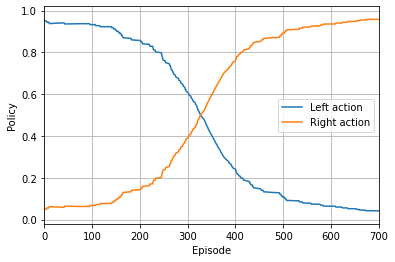

In [88]:
plotPolicy(policy_left, policy_right)

In [423]:
def plotTotalRewardEpisodes(total_reward_episodes, alg_label):
    if case_lbl=='NP':
        plt.axhline(y=reward_r, color='y', linestyle='-.', label='v*(s0)')
    elif case_lbl=='PP':
        plt.axhline(y=reward_r, color='y', linestyle='-.', label='v*(s0)')
    elif case_lbl=='NN':
        plt.axhline(y=-reward_l, color='y', linestyle='-.', label='v*(s0)')
    
    plt.plot(total_reward_episodes, label= alg_label) 
    plt.xlabel('Episode')
    plt.ylabel('G')
    plt.xlim(0,150)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [430]:
number_runs = 100
total_reward_episodes = np.zeros(1000)
for run in range(0,number_runs):
    reward_l, reward_r, case_lbl= 5, 10, 'NP'
    theta_start = 'Left' # Values: 'Left' and 'Right'
    w_start = 10 # Initialisation of parameter w
    env = RandomWalk(initialState=0, reward_left=reward_l, reward_right=reward_r, case_label=case_lbl)
    agent = PolicyGradient(gamma=1.0, alpha_theta=2**(-7), flag_with_baseline=0, first_action=0, theta_initialisation=theta_start, w_initialisation=w_start)
    reward_episodes, policy_left, policy_right = train(env, agent, nEpisode=1000)
    total_reward_episodes = total_reward_episodes + reward_episodes
total_reward_episodes = total_reward_episodes / number_runs

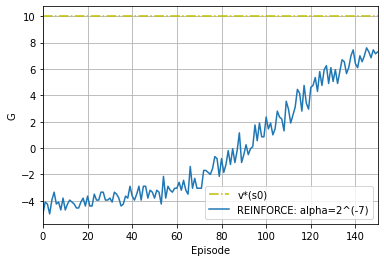

In [431]:
plotTotalRewardEpisodes(total_reward_episodes, 'REINFORCE: alpha=2^(-7)')